In [1]:
"""
DLF Assignment 2
Rui Pu a1679834
"""

'\nDLF Assignment 2\nRui Pu a1679834\n'

# About CIFAR-10

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

# Codes start here...

Import essential libraries

In [2]:
# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision import datasets, transforms

# NumPy
import numpy as np

# Plots
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('figure', dpi = 120)
plt.close('all')

Initialize GPU Usage

In [3]:
# Use GPU if available, else CPU
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
DEVICE

device(type='cuda', index=0)

# 1. Baseline CNN Architecture

There are 8 steps included:

1. Construct pipeline (transforms) FOR pre-processing images
2. Download, split and load the dataset
3. Define a BASELINE network architecture
4. Define training and validation method
5. Define the prediction method
6. Define loss function and optimizer
7. Train, validate and test using the baseline network architecture
8. Visualize the results

## 1.1. Construct pipeline (transforms) FOR pre-processing images

In [4]:
pipeline = transforms.Compose([
    transforms.ToTensor(), # Transferred to tensor
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]) # Normalization to range of [-1,1]

## 1.2. Download, split and load the dataset

In [5]:
# Download dataset
full_train_set = datasets.CIFAR10(root="./CIFAR10", train=True, download=True, transform=pipeline)
test_set = datasets.CIFAR10(root="./CIFAR10", train=False, download=True, transform=pipeline)

# Split full_train_set into train_set and val_set
train_set, val_set = random_split(full_train_set, [40000, 10000])

# Load dataset 
BATCH_SIZE = 10
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

# 10 classes/labels
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./CIFAR10/cifar-10-python.tar.gz to ./CIFAR10
Files already downloaded and verified


## 1.3. Define a baseline (LeNet) network architecture

In [6]:
class BaseNet(nn.Module): 
    
    def __init__(self):
        super().__init__()
        
        # Define layers
        self.conv1 = nn.Conv2d(3, 6, 5)   # Convolutional Layer 1: 6 5*5*3 kernels, stride=1, pad=1
        self.conv2 = nn.Conv2d(6, 16, 5)  # Convolutional Layer 2: 16 5*5*6 kernels, stride=1, pad=1
        self.pool = nn.MaxPool2d (2, 2)   # MaxPooling Layer: 2*2 filter, stride=2
        self.fc1 = nn.Linear(16*5*5, 120) # Fully Connected Layer 1 [input: 16*5*5, output: 120]
        self.fc2 = nn.Linear(120, 84)     # Fully Connected Layer 2 [input: 120, output: 84]
        self.fc3 = nn.Linear(84, 10)      # Fully Connected Layer 3 [input: 84, output: 10]
        
    def forward(self, x):
        
        x = self.pool(F.relu(self.conv1(x))) # Conv 1 + ReLU + MaxPooling: b*32*32*3 --> b*28*28*6 --> b*14*14*6
        x = self.pool(F.relu(self.conv2(x))) # Conv 2 + ReLU + MaxPooling: b*14*14*6 --> b*10*10*16 --> b*5*5*16
        
        x = x.view(-1, 5*5*16)    # Reshape and prepare for FC1
        x = F.relu(self.fc1(x))   # FC1 + ReLU: b*5*5*16 --> b*5*5*16 --> b*120
        x = F.relu(self.fc2(x))   # FC2 + ReLU: b*120    --> b*120    --> b*84
        x = self.fc3(x)           # FC3       : b*84     --> b*10     --> softmax later
        
        return x

base_model = BaseNet().to(DEVICE)
print(base_model)

BaseNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## 1.4. Define training and validation method

In [7]:
def train_and_validate(model, optimizer, train_loader, val_loader, epochs, batch_size, device, plot_history=True):
    
    running_loss_history = []
    running_corrects_history = []
    val_running_loss_history = []
    val_running_corrects_history = []

    for e in range(1, epochs+1):
        
        running_loss = 0.0
        running_corrects = 0.0
        val_running_loss = 0.0
        val_running_corrects = 0.0

        # Training:
        for inputs, labels in train_loader:

            # Send inputs to device
            inputs = inputs.to(device) 
            labels = labels.to(device)

            # Process: forward + backward + optimize
            outputs = model(inputs) # every batch of BATCH_SIZE images are put as an input
            loss = loss_function(outputs, labels) # compute loss after each batch by comparing it to actual labels

            optimizer.zero_grad() # initialize the parameter gradients to zero
            loss.backward() # backpropagating the loss
            optimizer.step() # updating the weights and bias values for every single step

            # Get loss and accuracy
            preds = outputs.argmax(dim=1) # taking the highest value of prediction
            running_loss += loss.item() # get all loss in a batch
            running_corrects += (preds==labels).sum().item() # take the sum of all correct predictions in a batch
            
        # Validation: same as training process above, but we do not need gradient for validation
        else:
            with torch.no_grad(): 
                for val_inputs, val_labels in val_loader:
                    val_inputs = val_inputs.to(device)
                    val_labels = val_labels.to(device)
                    val_outputs = model(val_inputs)
                    val_loss = loss_function(val_outputs, val_labels)
                    val_preds = val_outputs.argmax(dim=1)
                    val_running_loss += val_loss.item()
                    val_running_corrects += (val_preds==val_labels).sum().item()                   
                    
            # Get statistics
            epoch_loss = running_loss/len(train_loader) # loss per epoch
            epoch_acc = running_corrects/len(train_loader)/batch_size # accuracy per epoch per batch
            running_loss_history.append(epoch_loss) # appending for displaying 
            running_corrects_history.append(epoch_acc)

            val_epoch_loss = val_running_loss/len(val_loader)
            val_epoch_acc = val_running_corrects/len(val_loader)/batch_size
            val_running_loss_history.append(val_epoch_loss)
            val_running_corrects_history.append(val_epoch_acc)
            
            # Print results to screen
            print('epoch :', (e))
            print('train loss : {:.4f}, train accuracy : {:.2f} %'.format(epoch_loss, epoch_acc*100))
            print('val loss : {:.4f}, val accuracy : {:.2f} %'.format(val_epoch_loss, val_epoch_acc*100))
            print('----------------------------------------------')
    
    # Plot Training curves
    if  plot_history: 
        plt.plot(running_loss_history, label='training loss')
        plt.plot(val_running_loss_history, label='validation loss')
        plt.plot(running_corrects_history, label='training accuracy')
        plt.plot(val_running_corrects_history, label='validation accuracy')
        plt.plot(np.ones(len(running_loss_history)), linestyle = "dashed")
        plt.xlabel("Epochs")
        plt.title("Training Curves")
        plt.legend()
        plt.show()

## 1.5. Define the prediction method

In [8]:
# For overall and individual class
def predict(model, test_loader, batch_size, device, idv=True):
    test_corrects = 0.0
    class_corrects = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad(): # Same as validation process, we do not need gradient for test
        for test_inputs, test_labels in test_loader:
            test_inputs = test_inputs.to(device) # send test inputs to device as the model is running there
            test_labels = test_labels.to(device)
            test_outputs = model(test_inputs)
            test_preds = test_outputs.argmax(dim=1)
            
            # Take the sum of all the correct predictions in a batch
            test_corrects += (test_preds==test_labels).sum().item() 
            
            # Take the sum of correct predictions for each class
            c = (test_preds==test_labels).squeeze()
            for i in range(batch_size):
                label = test_labels[i]
                class_corrects[label] += c[i].item()
                class_total[label] += 1
                
    test_acc = test_corrects/len(test_loader)/batch_size # accuracy per epoch and batch
    print('Accuracy of the network on the 10000 test images : {:.2f} %'.format(100*test_acc))
    
    if idv:
        print('-----------------------------------------------------------')
        for i in range(10): # 10 classes
            print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_corrects[i] / class_total[i]))

## 1.6. Define loss function and optimizer

In [9]:
# For the baseline model...
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(base_model.parameters(), lr=0.001, momentum=0.9)

## 1.7. Train, validate and test using the built network

epoch : 1
train loss : 2.1009, train accuracy : 21.44 %
val loss : 1.7729, val accuracy : 35.44 %
----------------------------------------------
epoch : 2
train loss : 1.5696, train accuracy : 42.47 %
val loss : 1.4691, val accuracy : 46.30 %
----------------------------------------------
epoch : 3
train loss : 1.3983, train accuracy : 49.50 %
val loss : 1.4182, val accuracy : 48.52 %
----------------------------------------------
epoch : 4
train loss : 1.2912, train accuracy : 53.84 %
val loss : 1.3082, val accuracy : 52.89 %
----------------------------------------------
epoch : 5
train loss : 1.2075, train accuracy : 56.98 %
val loss : 1.2198, val accuracy : 56.27 %
----------------------------------------------
epoch : 6
train loss : 1.1395, train accuracy : 59.32 %
val loss : 1.2136, val accuracy : 56.48 %
----------------------------------------------
epoch : 7
train loss : 1.0798, train accuracy : 61.76 %
val loss : 1.1432, val accuracy : 59.40 %
--------------------------------

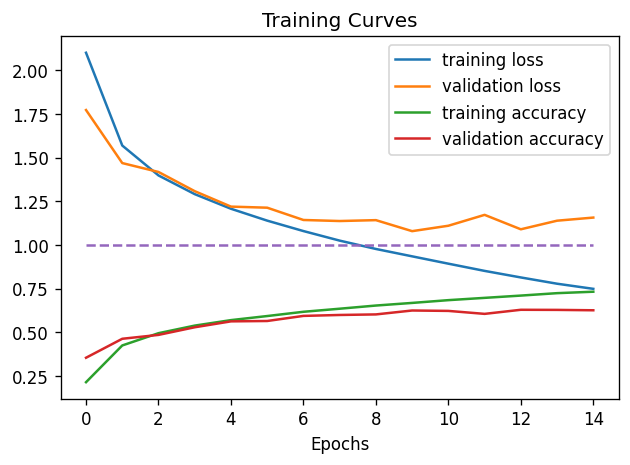

In [10]:
# Set the amount of epoches, trade-off between time and performance
EPOCHS = 15

# Get training loss&acc, validation loss&acc and training curves
train_and_validate(base_model, optimizer, train_loader, val_loader, EPOCHS, BATCH_SIZE, DEVICE)

In [11]:
# Get overall and individual prediction accs
predict(base_model, test_loader, BATCH_SIZE, DEVICE)

Accuracy of the network on the 10000 test images : 62.29 %
-----------------------------------------------------------
Accuracy of plane : 75 %
Accuracy of   car : 75 %
Accuracy of  bird : 46 %
Accuracy of   cat : 41 %
Accuracy of  deer : 63 %
Accuracy of   dog : 56 %
Accuracy of  frog : 74 %
Accuracy of horse : 54 %
Accuracy of  ship : 64 %
Accuracy of truck : 70 %


## 1.8. Visualize the results

In [12]:
def im_convert(img):
    img = img / 2 + 0.5 # inverse normalization
    img_np = img.cpu().numpy() # tensor -> numpy
    return np.transpose(img_np, (1, 2, 0))
    
def img_predict(model):

    # Get some random test images
    images, labels = next(iter(test_loader)) # test_loader is shuffled
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)
    output = model(images)
    preds = output.argmax(dim=1)
    
    # Show BATCH_SIZE test images with true and predicted labels
    fig = plt.figure(figsize=(18, 5))
    for i in np.arange(BATCH_SIZE):
        ax = fig.add_subplot(2, 5, i + 1, xticks = [], yticks = [])
        plt.imshow(im_convert(images[i]))
        ax.set_title(f'True: {classes[labels[i].item()]}, Pred: {classes[preds[i].item()]}', 
                     color = ("green" if preds[i] == labels[i] else "red"))

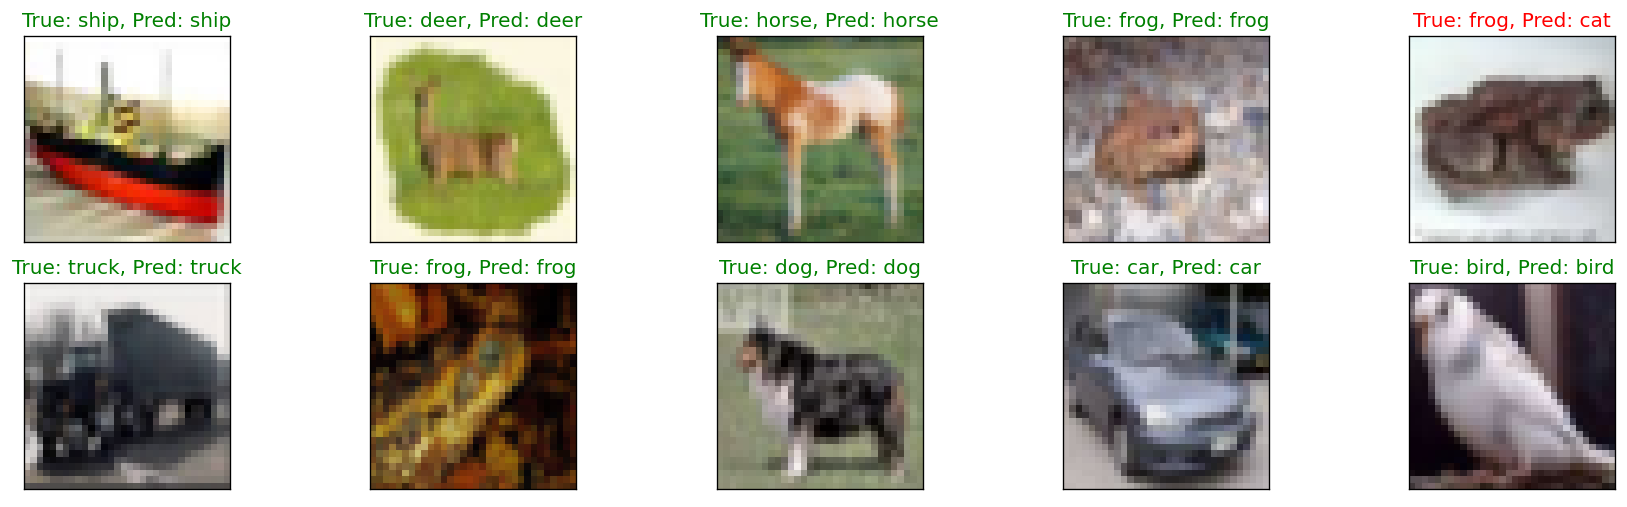

In [13]:
img_predict(base_model)

**Comments on the baseline CNN:**

* train accuracy 73.24% > test accuracy 62.62%: ~10.62% overfitting
* ~62.29% test accuracy
* individual test accuracy: lowest on "cat", highest on "plane" and "car"

# 2. Improvement on Networks

## 2.1. Add more CONV layers and kernels, and use padding

In [14]:
class Network1(nn.Module): 
    
    def __init__(self):
        super().__init__()
        
        # Define layers
        self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)   # Convolutional Layer 1: 16 3*3*3 kernels, stride=1, pad=1
        self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)  # Convolutional Layer 2: 32 3*3*16 kernels, stride=1, pad=1
        self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)  # Convolutional Layer 3: 64 3*3*32 kernels, stride=1, pad=1
        self.conv4 = nn.Conv2d(64, 128, 3, 1, padding=1) # Convolutional Layer 4: 128 3*3*64 kernels, stride=1, pad=1
        self.pool = nn.MaxPool2d (2, 2)    # MaxPooling Layer: 2*2 filter, stride=2
        self.fc1 = nn.Linear(8*8*128, 500) # Fully Connected Layer 1 [input: 8*8*128, output: 500]
        self.fc2 = nn.Linear(500, 100)     # Fully Connected Layer 2 [input: 500, output: 100]
        self.fc3 = nn.Linear(100, 10)      # Fully Connected Layer 3 [input: 100, output: 10]
        
    def forward(self, x):
        # (W1 − F + 2P )/S + 1 = (32-3+2)/1+1 = 32
        x = F.relu(self.conv1(x)) # Conv 1 + ReLU: b*32*32*3   -->  b*32*32*16  -->  b*32*32*16
        x = F.relu(self.conv2(x)) # Conv 2 + ReLU: b*32*32*16  -->  b*32*32*32  -->  b*32*32*32
        x = self.pool(x)          # MaxPooling   : b*32*32*32  -->  b*16*16*32
        x = F.relu(self.conv3(x)) # Conv 3 + ReLU: b*16*16*32  -->  b*16*16*64  -->  b*16*16*64
        x = F.relu(self.conv4(x)) # Conv 4 + ReLU: b*16*16*64  -->  b*16*16*128 -->  b*16*16*128
        x = self.pool(x)          # MaxPooling   : b*16*16*128 -->  b*8*8*128
        
        x = x.view(-1, 8*8*128)   # Reshape and prepare for FC1
        x = F.relu(self.fc1(x))   # FC1 + ReLU   : b*8*8*128 --> b*8*8*128 --> b*500
        x = F.relu(self.fc2(x))   # FC2 + ReLU   : b*500     --> b*100     --> b*100
        x = self.fc3(x)           # FC3          : b*100     --> b*10      --> softmax later
        
        return x

network1_model = Network1().to(DEVICE)
print(network1_model)

Network1(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


epoch : 1
train loss : 2.0604, train accuracy : 23.96 %
val loss : 1.7042, val accuracy : 38.53 %
----------------------------------------------
epoch : 2
train loss : 1.5582, train accuracy : 43.10 %
val loss : 1.4027, val accuracy : 48.94 %
----------------------------------------------
epoch : 3
train loss : 1.3001, train accuracy : 53.17 %
val loss : 1.2164, val accuracy : 55.40 %
----------------------------------------------
epoch : 4
train loss : 1.0964, train accuracy : 60.65 %
val loss : 1.0631, val accuracy : 62.05 %
----------------------------------------------
epoch : 5
train loss : 0.9131, train accuracy : 67.59 %
val loss : 0.9556, val accuracy : 66.62 %
----------------------------------------------
epoch : 6
train loss : 0.7507, train accuracy : 73.54 %
val loss : 0.8731, val accuracy : 69.50 %
----------------------------------------------
epoch : 7
train loss : 0.5888, train accuracy : 79.03 %
val loss : 0.8637, val accuracy : 70.83 %
--------------------------------

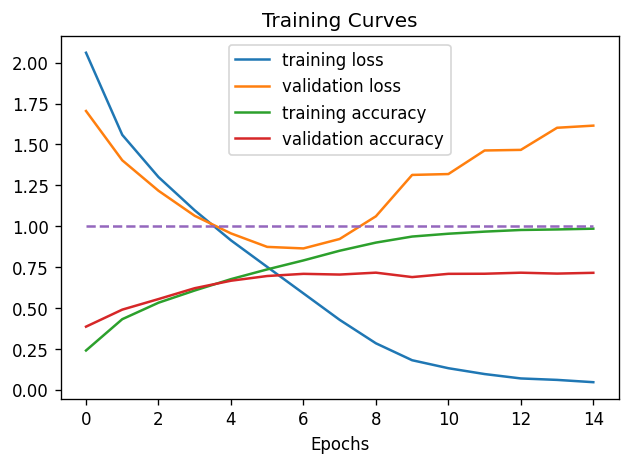

In [15]:
optimizer = optim.SGD(network1_model.parameters(), lr=0.001, momentum=0.9)
train_and_validate(network1_model, optimizer, train_loader, val_loader, EPOCHS, BATCH_SIZE, DEVICE)

In [16]:
predict(network1_model, test_loader, BATCH_SIZE, DEVICE)

Accuracy of the network on the 10000 test images : 71.98 %
-----------------------------------------------------------
Accuracy of plane : 77 %
Accuracy of   car : 85 %
Accuracy of  bird : 59 %
Accuracy of   cat : 58 %
Accuracy of  deer : 60 %
Accuracy of   dog : 62 %
Accuracy of  frog : 80 %
Accuracy of horse : 75 %
Accuracy of  ship : 84 %
Accuracy of truck : 75 %


**Comments on the Network1_model:**
* train accuracy 98.45% > test accuracy 71.46%: ~26.99% overfitting
* ~71.98% test accuracy
* individual test accuracy: lowest on "cat", highest on "car"

**Compared with the previous model - base_model:**
* Increase test accuracy from 62.29% to 71.98%, but very overfitting

**Next step:**
* Add "dropout" layers between FC layers based on Network1: to relieve overfitting

## 2.2. Add dropout layers between FC layers

In [17]:
class Network2(nn.Module): 
        
    def __init__(self):
        super().__init__()
        
        # Define layers
        self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)   # Convolutional Layer 1: 16 3*3*3 kernels, stride=1, pad=1
        self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)  # Convolutional Layer 2: 32 3*3*16 kernels, stride=1, pad=1
        self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)  # Convolutional Layer 3: 64 3*3*32 kernels, stride=1, pad=1
        self.conv4 = nn.Conv2d(64, 128, 3, 1, padding=1) # Convolutional Layer 4: 128 3*3*64 kernels, stride=1, pad=1
        self.pool = nn.MaxPool2d (2, 2)    # MaxPooling Layer: 2*2 filter, stride=2
        self.fc1 = nn.Linear(8*8*128, 500) # Fully Connected Layer 1 [input: 8*8*128, output: 500]
        self.fc2 = nn.Linear(500, 100)     # Fully Connected Layer 2 [input: 500, output: 100]
        self.fc3 = nn.Linear(100, 10)      # Fully Connected Layer 3 [input: 100, output: 10]
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        # (W1 − F + 2P )/S + 1 = (32-3+2)/1+1 = 32
        x = F.relu(self.conv1(x)) # Conv 1 + ReLU: b*32*32*3   -->  b*32*32*16  -->  b*32*32*16
        x = F.relu(self.conv2(x)) # Conv 2 + ReLU: b*32*32*16  -->  b*32*32*32  -->  b*32*32*32
        x = self.pool(x)          # MaxPooling   : b*32*32*32  -->  b*16*16*32
        x = F.relu(self.conv3(x)) # Conv 3 + ReLU: b*16*16*32  -->  b*16*16*64  -->  b*16*16*64
        x = F.relu(self.conv4(x)) # Conv 4 + ReLU: b*16*16*64  -->  b*16*16*128 -->  b*16*16*128
        x = self.pool(x)          # MaxPooling   : b*16*16*128 -->  b*8*8*128
        
        x = x.view(-1, 8*8*128)   # Reshape and prepare for FC1
        x = F.relu(self.fc1(x))   # FC1 + ReLU   : b*8*8*128 --> b*8*8*128 --> b*500
        x = self.dropout(x)
        x = F.relu(self.fc2(x))   # FC2 + ReLU   : b*500     --> b*100     --> b*100
        x = self.dropout(x)
        x = self.fc3(x)           # FC3          : b*100     --> b*10      --> softmax later
        
        return x

network2_model = Network2().to(DEVICE)
print(network2_model)

Network2(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


epoch : 1
train loss : 2.1305, train accuracy : 19.37 %
val loss : 1.8395, val accuracy : 31.43 %
----------------------------------------------
epoch : 2
train loss : 1.7174, train accuracy : 36.39 %
val loss : 1.5969, val accuracy : 40.65 %
----------------------------------------------
epoch : 3
train loss : 1.4984, train accuracy : 44.94 %
val loss : 1.4294, val accuracy : 47.69 %
----------------------------------------------
epoch : 4
train loss : 1.3011, train accuracy : 53.18 %
val loss : 1.2319, val accuracy : 55.97 %
----------------------------------------------
epoch : 5
train loss : 1.1433, train accuracy : 59.58 %
val loss : 1.1321, val accuracy : 60.24 %
----------------------------------------------
epoch : 6
train loss : 1.0116, train accuracy : 64.60 %
val loss : 0.9908, val accuracy : 65.93 %
----------------------------------------------
epoch : 7
train loss : 0.9034, train accuracy : 68.75 %
val loss : 0.9332, val accuracy : 68.14 %
--------------------------------

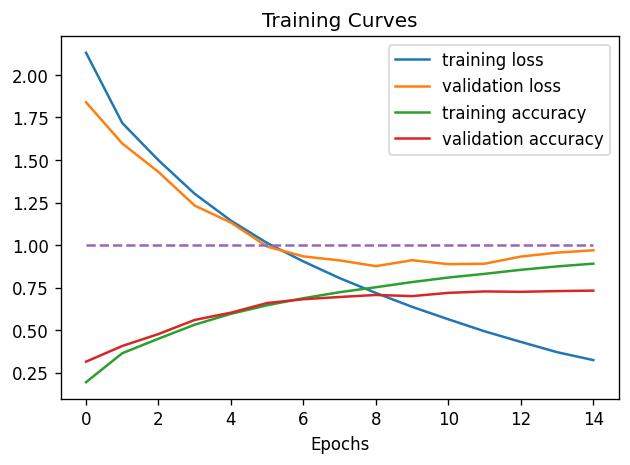

In [18]:
optimizer = optim.SGD(network2_model.parameters(), lr=0.001, momentum=0.9)
train_and_validate(network2_model, optimizer, train_loader, val_loader, EPOCHS, BATCH_SIZE, DEVICE)

In [19]:
predict(network2_model, test_loader, BATCH_SIZE, DEVICE)

Accuracy of the network on the 10000 test images : 72.67 %
-----------------------------------------------------------
Accuracy of plane : 72 %
Accuracy of   car : 85 %
Accuracy of  bird : 58 %
Accuracy of   cat : 54 %
Accuracy of  deer : 60 %
Accuracy of   dog : 64 %
Accuracy of  frog : 81 %
Accuracy of horse : 80 %
Accuracy of  ship : 85 %
Accuracy of truck : 84 %


**Comments on the Network2_model:**
* train accuracy 89.05% > test accuracy 73.20% : ~15.85% overfitting
* ~72.67% test accuracy
* individual test accuracy: lowest on "cat", highest on "ship" and "truck"

**Compared with the previous model - Network1_model:**
* Increase test accuracy from 71.98% to 72.67%, reduce overfitting

**Next step:**
* Add "BN" layers between Conv layers based on Network2: continue to relieve overfitting and increase accuracy

## 2.3. Add BN layers between Conv layers

In [20]:
class Network3(nn.Module): 
        
    def __init__(self):
        super().__init__()
        
        # Define layers
        self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)   # Convolutional Layer 1: 16 3*3*3 kernels, stride=1, pad=1
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)  # Convolutional Layer 2: 32 3*3*16 kernels, stride=1, pad=1
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)  # Convolutional Layer 3: 64 3*3*32 kernels, stride=1, pad=1
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, 3, 1, padding=1) # Convolutional Layer 4: 128 3*3*64 kernels, stride=1, pad=1
        self.bn4 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d (2, 2)    # MaxPooling Layer: 2*2 filter, stride=2
        self.fc1 = nn.Linear(8*8*128, 500) # Fully Connected Layer 1 [input: 8*8*128, output: 500]
        self.fc2 = nn.Linear(500, 100)     # Fully Connected Layer 2 [input: 500, output: 100]
        self.fc3 = nn.Linear(100, 10)      # Fully Connected Layer 3 [input: 100, output: 10]
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        # (W1 − F + 2P )/S + 1 = (32-3+2)/1+1 = 32
        x = F.relu(self.bn1(self.conv1(x))) # Conv 1 + BN1 + ReLU: b*32*32*3   -->  b*32*32*16  -->  b*32*32*16
        x = F.relu(self.bn2(self.conv2(x))) # Conv 2 + BN2 + ReLU: b*32*32*16  -->  b*32*32*32  -->  b*32*32*32
        x = self.pool(x)                    # MaxPooling   : b*32*32*32  -->  b*16*16*32
        x = F.relu(self.bn3(self.conv3(x))) # Conv 3 + BN3 + ReLU: b*16*16*32  -->  b*16*16*64  -->  b*16*16*64
        x = F.relu(self.bn4(self.conv4(x))) # Conv 4 + BN4 + ReLU: b*16*16*64  -->  b*16*16*128 -->  b*16*16*128
        x = self.pool(x)                    # MaxPooling   : b*16*16*128 -->  b*8*8*128
        
        x = x.view(-1, 8*8*128)   # Reshape and prepare for FC1
        x = F.relu(self.fc1(x))   # FC1 + ReLU   : b*8*8*128 --> b*8*8*128 --> b*500
        x = self.dropout(x)
        x = F.relu(self.fc2(x))   # FC2 + ReLU   : b*500     --> b*100     --> b*100
        x = self.dropout(x)
        x = self.fc3(x)           # FC3          : b*100     --> b*10      --> softmax later
        
        return x

network3_model = Network3().to(DEVICE)
print(network3_model)

Network3(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


epoch : 1
train loss : 1.6529, train accuracy : 38.70 %
val loss : 1.3991, val accuracy : 49.55 %
----------------------------------------------
epoch : 2
train loss : 1.2598, train accuracy : 55.35 %
val loss : 1.2076, val accuracy : 58.15 %
----------------------------------------------
epoch : 3
train loss : 1.0863, train accuracy : 62.39 %
val loss : 1.1330, val accuracy : 61.22 %
----------------------------------------------
epoch : 4
train loss : 0.9800, train accuracy : 66.54 %
val loss : 0.9755, val accuracy : 67.10 %
----------------------------------------------
epoch : 5
train loss : 0.8936, train accuracy : 69.82 %
val loss : 0.9437, val accuracy : 69.34 %
----------------------------------------------
epoch : 6
train loss : 0.8355, train accuracy : 71.58 %
val loss : 0.9142, val accuracy : 69.97 %
----------------------------------------------
epoch : 7
train loss : 0.7786, train accuracy : 73.54 %
val loss : 0.8645, val accuracy : 71.12 %
--------------------------------

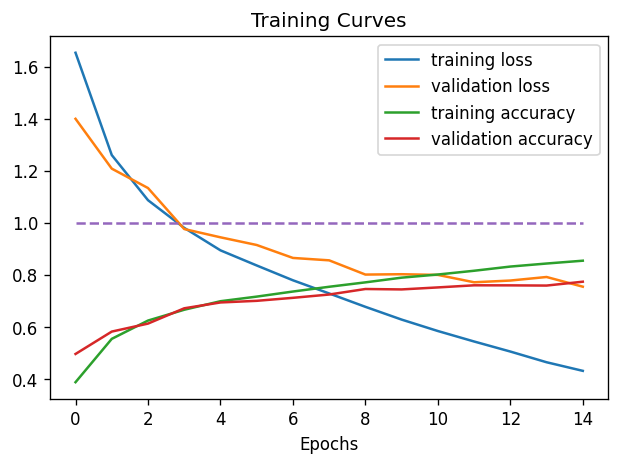

In [21]:
optimizer = optim.SGD(network3_model.parameters(), lr=0.001, momentum=0.9)
train_and_validate(network3_model, optimizer, train_loader, val_loader, EPOCHS, BATCH_SIZE, DEVICE)

In [22]:
predict(network3_model, test_loader, BATCH_SIZE, DEVICE)

Accuracy of the network on the 10000 test images : 76.77 %
-----------------------------------------------------------
Accuracy of plane : 76 %
Accuracy of   car : 87 %
Accuracy of  bird : 68 %
Accuracy of   cat : 65 %
Accuracy of  deer : 75 %
Accuracy of   dog : 56 %
Accuracy of  frog : 82 %
Accuracy of horse : 78 %
Accuracy of  ship : 89 %
Accuracy of truck : 86 %


**Comments on the Network3_model:**
* train accuracy 85.39% > test accuracy 77.32%: ~8.07% overfitting
* ~76.77% test accuracy
* individual test accuracy: lowest on "cat", highest on "ship"

**Compared with the previous model - Network2_model:**
* Increase test accuracy from 72.67% to 76.77%, still overfitting

**Next step:**
* Tuning optimizers and learning rates based on Network3: to increase accuracy and reduce overfitting

# 3. Manual Explorations of Optimizers and Their Learning Rates:

* Optimizers: SGD with Momentum, Adam, RMSprop
* Learning rate range: [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
* Mannually stop running when lr contributes to a bad performance

In [23]:
def tune_opti_lr(optimizer_name, tuned_lr):
    
    model = Network3().to(DEVICE)
    
    if optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr = tuned_lr, momentum=0.9)
    elif optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr = tuned_lr)
    elif optimizer_name == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr = tuned_lr)
        
    print(f'Optimizer : {optimizer_name}, Learning Rate : {tuned_lr}.')
    print('-----------------------------------------------------------')
    train_and_validate(model, optimizer, train_loader, val_loader, EPOCHS, BATCH_SIZE, DEVICE)
    predict(model, test_loader, BATCH_SIZE, DEVICE, idv=False)       

## 3.1. Optimizer: SGD with Momentum; lr: [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]

### 3.1.1. Optimizer: SGD with Momentum; Learning Rate: 0.00001

Optimizer : SGD, Learning Rate : 1e-05.
-----------------------------------------------------------
epoch : 1
train loss : 2.2727, train accuracy : 13.15 %
val loss : 2.2241, val accuracy : 16.89 %
----------------------------------------------
epoch : 2
train loss : 2.1626, train accuracy : 20.87 %
val loss : 2.1104, val accuracy : 22.91 %
----------------------------------------------
epoch : 3
train loss : 2.0553, train accuracy : 25.97 %
val loss : 2.0059, val accuracy : 27.70 %
----------------------------------------------
epoch : 4
train loss : 1.9549, train accuracy : 29.68 %
val loss : 1.9166, val accuracy : 30.58 %
----------------------------------------------
epoch : 5
train loss : 1.8704, train accuracy : 31.86 %
val loss : 1.8440, val accuracy : 32.64 %
----------------------------------------------
epoch : 6
train loss : 1.8028, train accuracy : 34.17 %
val loss : 1.7715, val accuracy : 35.58 %
----------------------------------------------
epoch : 7
train loss : 1.7420,

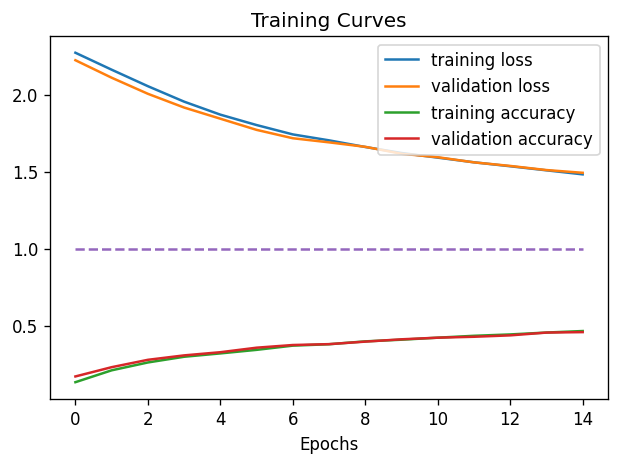

Accuracy of the network on the 10000 test images : 46.31 %


In [24]:
tuned_lr = 0.00001
tune_opti_lr("SGD", tuned_lr)

### 3.1.2. Optimizer: SGD with Momentum; Learning Rate: 0.00005

Optimizer : SGD, Learning Rate : 5e-05.
-----------------------------------------------------------
epoch : 1
train loss : 2.1038, train accuracy : 22.22 %
val loss : 1.8737, val accuracy : 30.91 %
----------------------------------------------
epoch : 2
train loss : 1.7436, train accuracy : 35.65 %
val loss : 1.6616, val accuracy : 39.24 %
----------------------------------------------
epoch : 3
train loss : 1.5725, train accuracy : 42.22 %
val loss : 1.5250, val accuracy : 43.98 %
----------------------------------------------
epoch : 4
train loss : 1.4600, train accuracy : 47.17 %
val loss : 1.4247, val accuracy : 48.33 %
----------------------------------------------
epoch : 5
train loss : 1.3752, train accuracy : 50.89 %
val loss : 1.3665, val accuracy : 51.17 %
----------------------------------------------
epoch : 6
train loss : 1.2931, train accuracy : 53.61 %
val loss : 1.2893, val accuracy : 54.50 %
----------------------------------------------
epoch : 7
train loss : 1.2235,

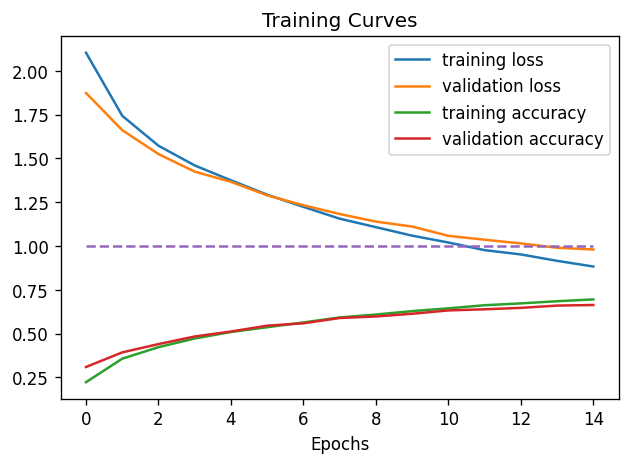

Accuracy of the network on the 10000 test images : 66.55 %


In [25]:
tuned_lr = 0.00005
tune_opti_lr("SGD", tuned_lr)

### 3.1.3. Optimizer: SGD with Momentum; Learning Rate: 0.0001

Optimizer : SGD, Learning Rate : 0.0001.
-----------------------------------------------------------
epoch : 1
train loss : 1.9565, train accuracy : 27.23 %
val loss : 1.7056, val accuracy : 36.25 %
----------------------------------------------
epoch : 2
train loss : 1.5690, train accuracy : 42.47 %
val loss : 1.4897, val accuracy : 45.51 %
----------------------------------------------
epoch : 3
train loss : 1.3870, train accuracy : 49.78 %
val loss : 1.3421, val accuracy : 51.43 %
----------------------------------------------
epoch : 4
train loss : 1.2544, train accuracy : 55.32 %
val loss : 1.2259, val accuracy : 56.41 %
----------------------------------------------
epoch : 5
train loss : 1.1455, train accuracy : 59.31 %
val loss : 1.1606, val accuracy : 58.57 %
----------------------------------------------
epoch : 6
train loss : 1.0710, train accuracy : 62.49 %
val loss : 1.0970, val accuracy : 61.76 %
----------------------------------------------
epoch : 7
train loss : 1.0082

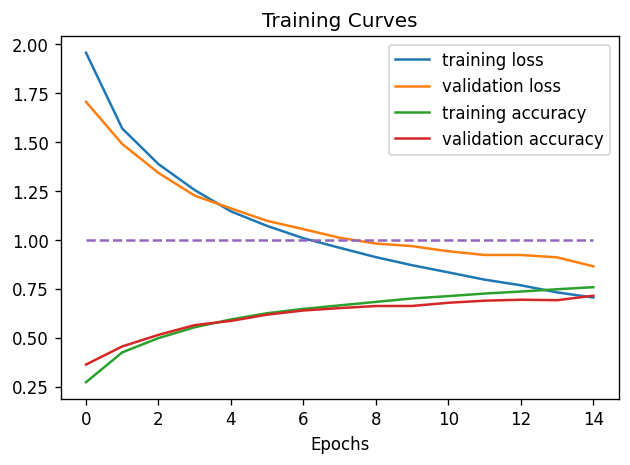

Accuracy of the network on the 10000 test images : 70.33 %


In [26]:
tuned_lr = 0.0001
tune_opti_lr("SGD", tuned_lr)

### 3.1.4. Optimizer: SGD with Momentum; Learning Rate: 0.0005

Optimizer : SGD, Learning Rate : 0.0005.
-----------------------------------------------------------
epoch : 1
train loss : 1.6561, train accuracy : 38.83 %
val loss : 1.4035, val accuracy : 48.46 %
----------------------------------------------
epoch : 2
train loss : 1.2767, train accuracy : 54.34 %
val loss : 1.2802, val accuracy : 54.75 %
----------------------------------------------
epoch : 3
train loss : 1.1105, train accuracy : 60.79 %
val loss : 1.0733, val accuracy : 62.15 %
----------------------------------------------
epoch : 4
train loss : 0.9910, train accuracy : 65.58 %
val loss : 1.0114, val accuracy : 65.86 %
----------------------------------------------
epoch : 5
train loss : 0.9104, train accuracy : 68.70 %
val loss : 0.9169, val accuracy : 68.55 %
----------------------------------------------
epoch : 6
train loss : 0.8421, train accuracy : 71.22 %
val loss : 0.9457, val accuracy : 68.10 %
----------------------------------------------
epoch : 7
train loss : 0.7856

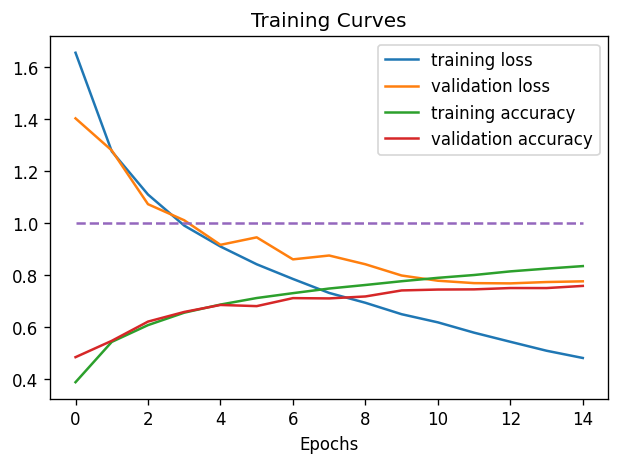

Accuracy of the network on the 10000 test images : 75.71 %


In [27]:
tuned_lr = 0.0005
tune_opti_lr("SGD", tuned_lr)

### 3.1.5. Optimizer: SGD with Momentum; Learning Rate: 0.001 (Network3_model)

In [28]:
# tuned_lr = 0.001
# tune_opti_lr("SGD", tuned_lr)

### 3.1.6. Optimizer: SGD with Momentum; Learning Rate: 0.005

Optimizer : SGD, Learning Rate : 0.005.
-----------------------------------------------------------
epoch : 1
train loss : 1.9902, train accuracy : 24.52 %
val loss : 1.8111, val accuracy : 29.41 %
----------------------------------------------
epoch : 2
train loss : 1.6647, train accuracy : 38.07 %
val loss : 1.5408, val accuracy : 45.80 %
----------------------------------------------
epoch : 3
train loss : 1.3339, train accuracy : 52.84 %
val loss : 1.2017, val accuracy : 58.61 %
----------------------------------------------
epoch : 4
train loss : 1.1021, train accuracy : 62.56 %
val loss : 1.1266, val accuracy : 62.23 %
----------------------------------------------
epoch : 5
train loss : 0.9541, train accuracy : 67.98 %
val loss : 0.9582, val accuracy : 68.67 %
----------------------------------------------
epoch : 6
train loss : 0.8411, train accuracy : 72.04 %
val loss : 0.9156, val accuracy : 69.60 %
----------------------------------------------
epoch : 7
train loss : 0.7580,

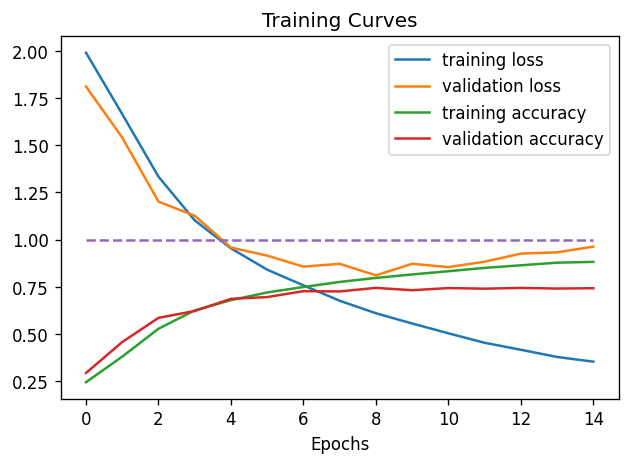

Accuracy of the network on the 10000 test images : 74.23 %


In [29]:
tuned_lr = 0.005
tune_opti_lr("SGD", tuned_lr)

### 3.1.7. Optimizer: SGD with Momentum; Learning Rate: 0.01

Optimizer : SGD, Learning Rate : 0.01.
-----------------------------------------------------------
epoch : 1
train loss : 2.1390, train accuracy : 17.96 %
val loss : 2.0219, val accuracy : 21.64 %
----------------------------------------------
epoch : 2
train loss : 1.7746, train accuracy : 32.72 %
val loss : 1.5741, val accuracy : 41.94 %
----------------------------------------------
epoch : 3
train loss : 1.4606, train accuracy : 47.83 %
val loss : 1.3968, val accuracy : 50.75 %
----------------------------------------------
epoch : 4
train loss : 1.2754, train accuracy : 56.09 %
val loss : 1.2264, val accuracy : 57.43 %
----------------------------------------------
epoch : 5
train loss : 1.1483, train accuracy : 61.86 %
val loss : 1.2001, val accuracy : 60.66 %
----------------------------------------------
epoch : 6
train loss : 1.0620, train accuracy : 65.07 %
val loss : 1.1086, val accuracy : 63.87 %
----------------------------------------------
epoch : 7
train loss : 0.9996, 

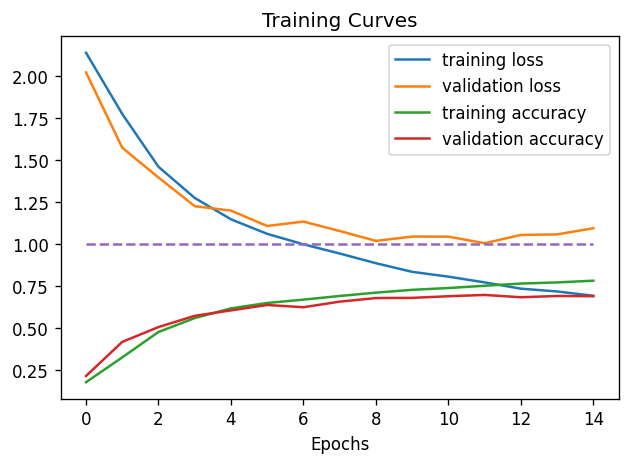

Accuracy of the network on the 10000 test images : 70.06 %


In [30]:
tuned_lr = 0.01
tune_opti_lr("SGD", tuned_lr)

### 3.1.8. Optimizer: SGD with Momentum; Learning Rate: 0.05

Optimizer : SGD, Learning Rate : 0.05.
-----------------------------------------------------------
epoch : 1
train loss : nan, train accuracy : 9.96 %
val loss : nan, val accuracy : 9.97 %
----------------------------------------------
epoch : 2
train loss : nan, train accuracy : 10.01 %
val loss : nan, val accuracy : 9.97 %
----------------------------------------------
epoch : 3
train loss : nan, train accuracy : 10.01 %
val loss : nan, val accuracy : 9.97 %
----------------------------------------------
epoch : 4
train loss : nan, train accuracy : 10.01 %
val loss : nan, val accuracy : 9.97 %
----------------------------------------------
epoch : 5
train loss : nan, train accuracy : 10.01 %
val loss : nan, val accuracy : 9.97 %
----------------------------------------------
epoch : 6
train loss : nan, train accuracy : 10.01 %
val loss : nan, val accuracy : 9.97 %
----------------------------------------------
epoch : 7
train loss : nan, train accuracy : 10.01 %
val loss : nan, val a

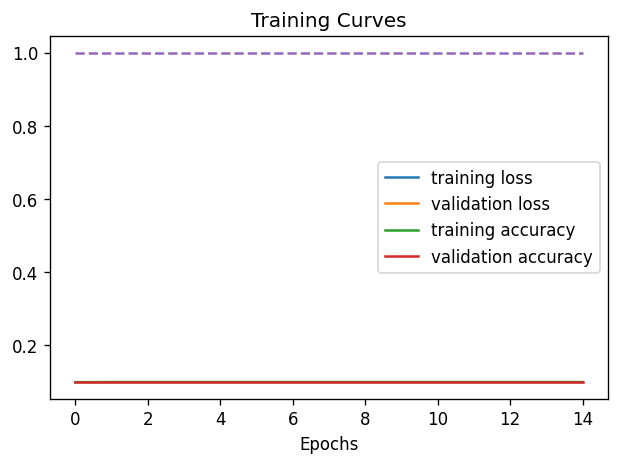

Accuracy of the network on the 10000 test images : 10.00 %


In [31]:
tuned_lr = 0.05
tune_opti_lr("SGD", tuned_lr)

### 3.1.9. Optimizer: SGD with Momentum; Learning Rate: 0.1

Optimizer : SGD, Learning Rate : 0.1.
-----------------------------------------------------------
epoch : 1
train loss : nan, train accuracy : 10.00 %
val loss : nan, val accuracy : 9.97 %
----------------------------------------------
epoch : 2
train loss : nan, train accuracy : 10.01 %
val loss : nan, val accuracy : 9.97 %
----------------------------------------------
epoch : 3
train loss : nan, train accuracy : 10.01 %
val loss : nan, val accuracy : 9.97 %
----------------------------------------------
epoch : 4
train loss : nan, train accuracy : 10.01 %
val loss : nan, val accuracy : 9.97 %
----------------------------------------------
epoch : 5
train loss : nan, train accuracy : 10.01 %
val loss : nan, val accuracy : 9.97 %
----------------------------------------------
epoch : 6
train loss : nan, train accuracy : 10.01 %
val loss : nan, val accuracy : 9.97 %
----------------------------------------------
epoch : 7
train loss : nan, train accuracy : 10.01 %
val loss : nan, val a

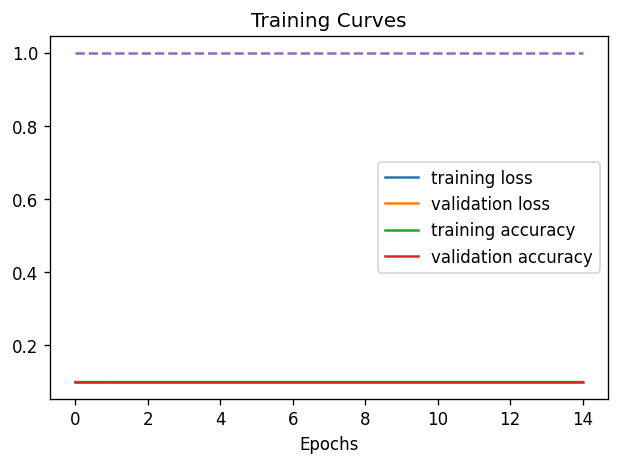

Accuracy of the network on the 10000 test images : 10.00 %


In [32]:
tuned_lr = 0.1
tune_opti_lr("SGD", tuned_lr)

**Comments on SGD with Momentum optimizer:**

|LR     |Train %|Val %  |Tr-Val%|Test % |
|:------|-------|-------|-------|-------|
|0.00001| 46.41 | 45.70 |  0.71 | 46.31 |
|0.00005| 69.49 | 66.30 |  3.19 | 66.55 |
|0.0001 | 75.81 | 71.45 |  4.36 | 70.33 |
|0.0005 | 83.51 | 75.88 |  7.63 | 75.71 |
|0.001  | 85.39 | 77.32 |  8.07 | 76.77 |
|0.005  | 88.25 | 74.28 | 13.97 | 74.23 |
|0.01   | 78.33 | 69.08 |  9.25 | 70.06 |
|0.05   |   -   |   -   |   -   |   -   |
|0.1    |   -   |   -   |   -   |   -   |

## 3.2. Optimizer: Adam; lr: [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]

### 3.2.1. Optimizer: Adam; Learning Rate: 0.00001

Optimizer : Adam, Learning Rate : 1e-05.
-----------------------------------------------------------
epoch : 1
train loss : 1.9157, train accuracy : 29.45 %
val loss : 1.7121, val accuracy : 37.48 %
----------------------------------------------
epoch : 2
train loss : 1.6185, train accuracy : 41.49 %
val loss : 1.5451, val accuracy : 44.83 %
----------------------------------------------
epoch : 3
train loss : 1.4648, train accuracy : 47.98 %
val loss : 1.4397, val accuracy : 49.10 %
----------------------------------------------
epoch : 4
train loss : 1.3466, train accuracy : 52.31 %
val loss : 1.3303, val accuracy : 53.06 %
----------------------------------------------
epoch : 5
train loss : 1.2630, train accuracy : 55.73 %
val loss : 1.2760, val accuracy : 55.29 %
----------------------------------------------
epoch : 6
train loss : 1.1901, train accuracy : 58.43 %
val loss : 1.2187, val accuracy : 57.38 %
----------------------------------------------
epoch : 7
train loss : 1.1332

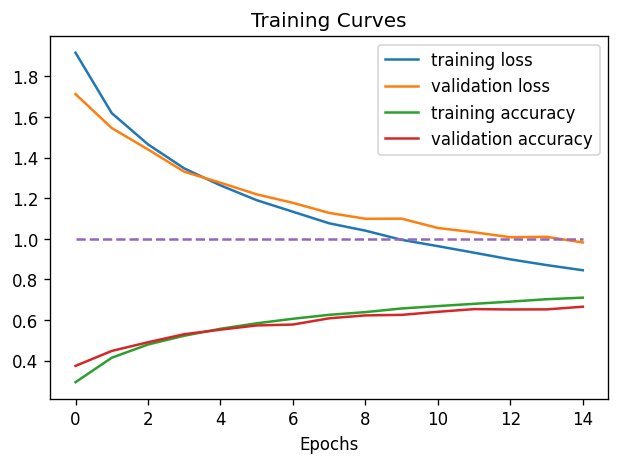

Accuracy of the network on the 10000 test images : 66.03 %


In [33]:
tuned_lr = 0.00001
tune_opti_lr("Adam", tuned_lr)

### 3.2.2. Optimizer: Adam; Learning Rate: 0.00005

Optimizer : Adam, Learning Rate : 5e-05.
-----------------------------------------------------------
epoch : 1
train loss : 1.7595, train accuracy : 35.41 %
val loss : 1.5208, val accuracy : 45.58 %
----------------------------------------------
epoch : 2
train loss : 1.3765, train accuracy : 51.09 %
val loss : 1.3039, val accuracy : 53.94 %
----------------------------------------------
epoch : 3
train loss : 1.2072, train accuracy : 57.99 %
val loss : 1.2017, val accuracy : 58.57 %
----------------------------------------------
epoch : 4
train loss : 1.0955, train accuracy : 62.27 %
val loss : 1.1406, val accuracy : 60.71 %
----------------------------------------------
epoch : 5
train loss : 1.0099, train accuracy : 65.37 %
val loss : 1.0600, val accuracy : 63.77 %
----------------------------------------------
epoch : 6
train loss : 0.9376, train accuracy : 68.19 %
val loss : 1.0157, val accuracy : 65.86 %
----------------------------------------------
epoch : 7
train loss : 0.8827

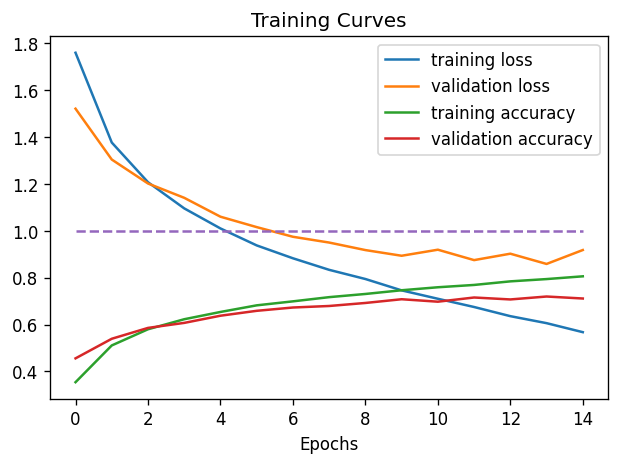

Accuracy of the network on the 10000 test images : 70.82 %


In [34]:
tuned_lr = 0.00005
tune_opti_lr("Adam", tuned_lr)

### 3.2.3. Optimizer: Adam; Learning Rate: 0.0001

Optimizer : Adam, Learning Rate : 0.0001.
-----------------------------------------------------------
epoch : 1
train loss : 1.7185, train accuracy : 36.78 %
val loss : 1.4834, val accuracy : 46.18 %
----------------------------------------------
epoch : 2
train loss : 1.3382, train accuracy : 52.49 %
val loss : 1.2740, val accuracy : 56.00 %
----------------------------------------------
epoch : 3
train loss : 1.1630, train accuracy : 59.26 %
val loss : 1.1643, val accuracy : 59.77 %
----------------------------------------------
epoch : 4
train loss : 1.0576, train accuracy : 63.59 %
val loss : 1.0723, val accuracy : 63.48 %
----------------------------------------------
epoch : 5
train loss : 0.9777, train accuracy : 66.47 %
val loss : 1.0266, val accuracy : 65.86 %
----------------------------------------------
epoch : 6
train loss : 0.9191, train accuracy : 69.02 %
val loss : 0.9877, val accuracy : 67.17 %
----------------------------------------------
epoch : 7
train loss : 0.869

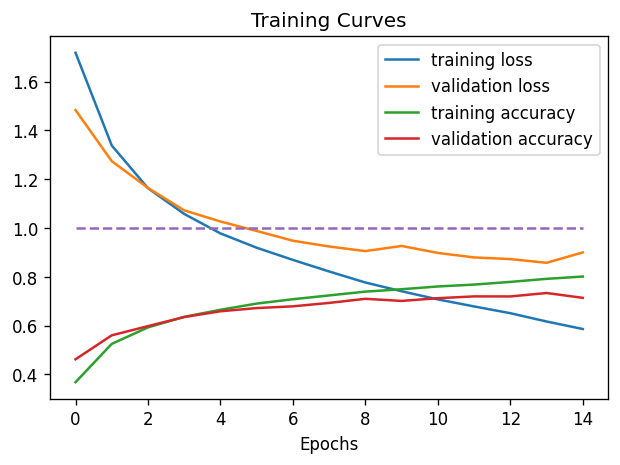

Accuracy of the network on the 10000 test images : 71.72 %


In [35]:
tuned_lr = 0.0001
tune_opti_lr("Adam", tuned_lr)

### 3.2.4. Optimizer: Adam; Learning Rate: 0.0005

Optimizer : Adam, Learning Rate : 0.0005.
-----------------------------------------------------------
epoch : 1
train loss : 1.7434, train accuracy : 35.61 %
val loss : 1.4803, val accuracy : 47.16 %
----------------------------------------------
epoch : 2
train loss : 1.3347, train accuracy : 52.88 %
val loss : 1.2838, val accuracy : 56.42 %
----------------------------------------------
epoch : 3
train loss : 1.1510, train accuracy : 60.16 %
val loss : 1.1532, val accuracy : 61.22 %
----------------------------------------------
epoch : 4
train loss : 1.0354, train accuracy : 64.89 %
val loss : 1.0589, val accuracy : 63.91 %
----------------------------------------------
epoch : 5
train loss : 0.9503, train accuracy : 67.96 %
val loss : 1.0181, val accuracy : 66.27 %
----------------------------------------------
epoch : 6
train loss : 0.8806, train accuracy : 70.70 %
val loss : 0.9662, val accuracy : 68.47 %
----------------------------------------------
epoch : 7
train loss : 0.817

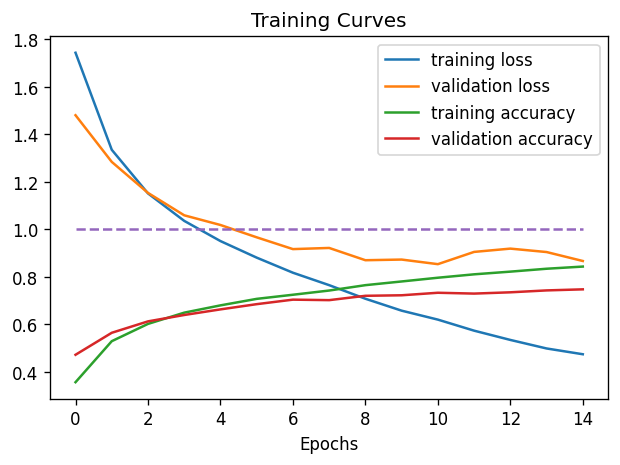

Accuracy of the network on the 10000 test images : 73.97 %


In [36]:
tuned_lr = 0.0005
tune_opti_lr("Adam", tuned_lr)

### 3.2.5. Optimizer: Adam; Learning Rate: 0.001

Optimizer : Adam, Learning Rate : 0.001.
-----------------------------------------------------------
epoch : 1
train loss : 1.8479, train accuracy : 30.64 %
val loss : 1.6140, val accuracy : 39.95 %
----------------------------------------------
epoch : 2
train loss : 1.4498, train accuracy : 48.28 %
val loss : 1.3578, val accuracy : 52.56 %
----------------------------------------------
epoch : 3
train loss : 1.2598, train accuracy : 56.09 %
val loss : 1.2177, val accuracy : 58.77 %
----------------------------------------------
epoch : 4
train loss : 1.1297, train accuracy : 60.76 %
val loss : 1.1038, val accuracy : 62.26 %
----------------------------------------------
epoch : 5
train loss : 1.0387, train accuracy : 64.97 %
val loss : 1.0961, val accuracy : 63.25 %
----------------------------------------------
epoch : 6
train loss : 0.9487, train accuracy : 68.24 %
val loss : 1.0358, val accuracy : 65.86 %
----------------------------------------------
epoch : 7
train loss : 0.8766

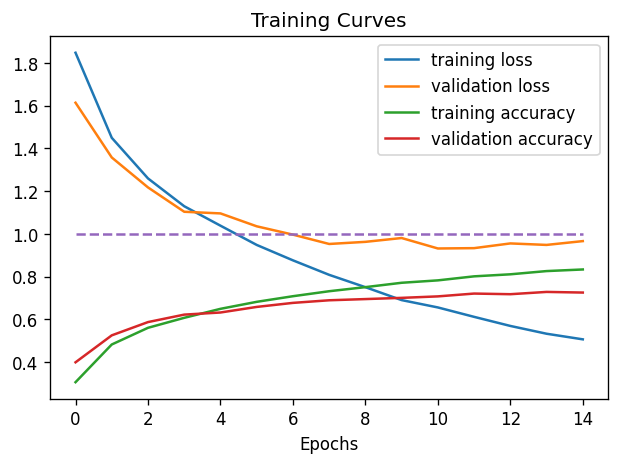

Accuracy of the network on the 10000 test images : 72.54 %


In [37]:
tuned_lr = 0.001
tune_opti_lr("Adam", tuned_lr)

### 3.2.6. Optimizer: Adam; Learning Rate: 0.005

Optimizer : Adam, Learning Rate : 0.005.
-----------------------------------------------------------
epoch : 1
train loss : 2.3384, train accuracy : 10.01 %
val loss : 2.3040, val accuracy : 9.48 %
----------------------------------------------
epoch : 2
train loss : 2.3071, train accuracy : 9.94 %
val loss : 2.3034, val accuracy : 10.33 %
----------------------------------------------
epoch : 3
train loss : 2.3042, train accuracy : 10.07 %
val loss : 2.3031, val accuracy : 10.37 %
----------------------------------------------
epoch : 4
train loss : 2.3057, train accuracy : 9.64 %
val loss : 2.3035, val accuracy : 10.07 %
----------------------------------------------
epoch : 5
train loss : 2.3057, train accuracy : 9.88 %
val loss : 2.3029, val accuracy : 10.37 %
----------------------------------------------
epoch : 6
train loss : 2.3038, train accuracy : 10.14 %
val loss : 2.3052, val accuracy : 9.57 %
----------------------------------------------
epoch : 7
train loss : 2.3038, tra

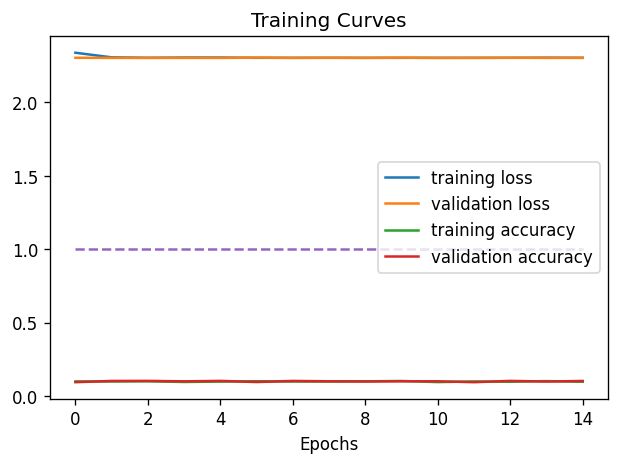

Accuracy of the network on the 10000 test images : 10.00 %


In [38]:
tuned_lr = 0.005
tune_opti_lr("Adam", tuned_lr)

### 3.2.7. Optimizer: Adam; Learning Rate: 0.01

Optimizer : Adam, Learning Rate : 0.01.
-----------------------------------------------------------
epoch : 1
train loss : 2.3713, train accuracy : 9.90 %
val loss : 2.3042, val accuracy : 9.84 %
----------------------------------------------
epoch : 2
train loss : 2.3210, train accuracy : 10.00 %
val loss : 2.3669, val accuracy : 10.38 %
----------------------------------------------
epoch : 3
train loss : 2.3103, train accuracy : 9.97 %
val loss : 2.3062, val accuracy : 9.84 %
----------------------------------------------
epoch : 4
train loss : 2.3063, train accuracy : 9.88 %
val loss : 2.3059, val accuracy : 10.08 %
----------------------------------------------
epoch : 5
train loss : 2.3073, train accuracy : 10.02 %
val loss : 2.3074, val accuracy : 9.92 %
----------------------------------------------
epoch : 6
train loss : 2.3052, train accuracy : 9.83 %
val loss : 2.3048, val accuracy : 10.37 %
----------------------------------------------
epoch : 7
train loss : 2.3050, train 

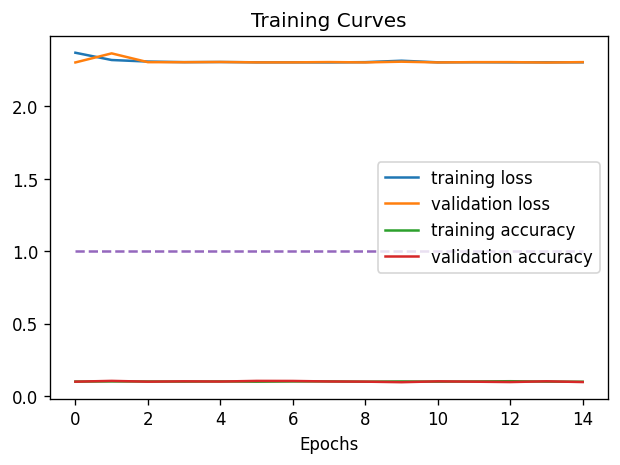

Accuracy of the network on the 10000 test images : 10.00 %


In [39]:
tuned_lr = 0.01
tune_opti_lr("Adam", tuned_lr)

### 3.2.8. Optimizer: Adam; Learning Rate: 0.05

Optimizer : Adam, Learning Rate : 0.05.
-----------------------------------------------------------
epoch : 1
train loss : 3.2938, train accuracy : 9.84 %
val loss : 2.3117, val accuracy : 10.10 %
----------------------------------------------
epoch : 2
train loss : 2.3149, train accuracy : 9.88 %
val loss : 2.3118, val accuracy : 10.10 %
----------------------------------------------
epoch : 3
train loss : 2.3141, train accuracy : 9.86 %
val loss : 2.3098, val accuracy : 9.97 %
----------------------------------------------
epoch : 4
train loss : 2.3149, train accuracy : 9.91 %
val loss : 2.3067, val accuracy : 10.37 %
----------------------------------------------
epoch : 5
train loss : 2.3149, train accuracy : 9.78 %
val loss : 2.3154, val accuracy : 9.58 %
----------------------------------------------
epoch : 6
train loss : 2.3146, train accuracy : 10.08 %
val loss : 2.3198, val accuracy : 10.10 %
----------------------------------------------
epoch : 7
train loss : 4.4980, train 

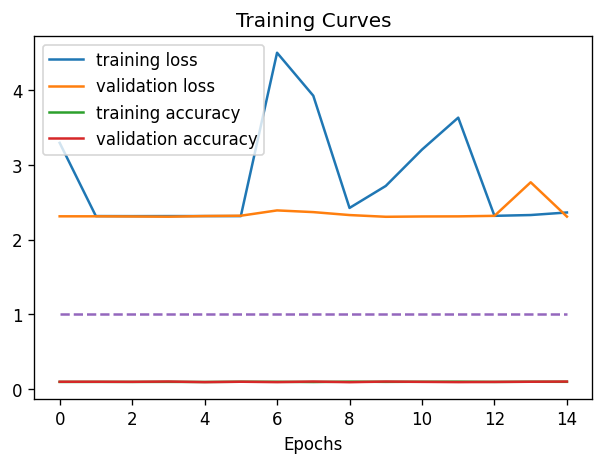

Accuracy of the network on the 10000 test images : 10.00 %


In [40]:
tuned_lr = 0.05
tune_opti_lr("Adam", tuned_lr)

### 3.2.9. Optimizer: Adam; Learning Rate: 0.1

Optimizer : Adam, Learning Rate : 0.1.
-----------------------------------------------------------
epoch : 1
train loss : 6.9110, train accuracy : 10.39 %
val loss : 2.3158, val accuracy : 9.58 %
----------------------------------------------
epoch : 2
train loss : 2.3263, train accuracy : 9.98 %
val loss : 2.3154, val accuracy : 10.33 %
----------------------------------------------
epoch : 3
train loss : 2.3269, train accuracy : 9.82 %
val loss : 2.3243, val accuracy : 10.37 %
----------------------------------------------
epoch : 4
train loss : 2.3266, train accuracy : 9.87 %
val loss : 2.3105, val accuracy : 9.58 %
----------------------------------------------
epoch : 5
train loss : 2.3251, train accuracy : 9.99 %
val loss : 2.3352, val accuracy : 9.48 %
----------------------------------------------
epoch : 6
train loss : 2.3251, train accuracy : 10.02 %
val loss : 2.3225, val accuracy : 10.33 %
----------------------------------------------
epoch : 7
train loss : 2.3263, train a

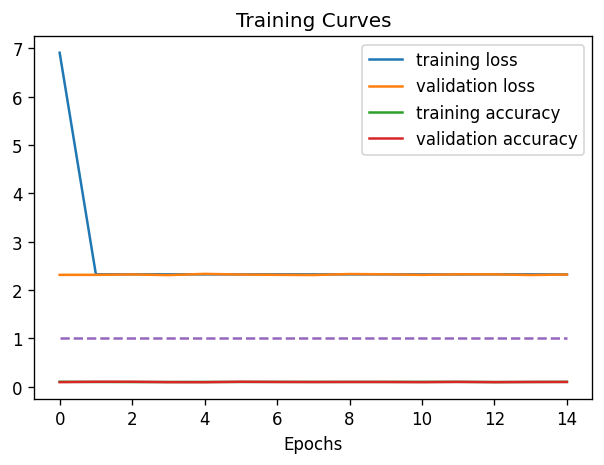

Accuracy of the network on the 10000 test images : 10.00 %


In [41]:
tuned_lr = 0.1
tune_opti_lr("Adam", tuned_lr)

**Comments on Adam optimizer:**

|LR     |Train %|Val %  |Tr-Val%|Test % |
|:------|-------|-------|-------|-------|
|0.00001| 71.05 | 66.59 |  4.46 | 66.03 |  
|0.00005| 80.58 | 71.11 |  9.47 | 70.82 |  
|0.0001 | 80.09 | 71.36 |  8.73 | 71.72 |  
|0.0005 | 84.30 | 74.71 |  9.59 | 73.97 |  
|0.001  | 83.38 | 72.58 | 10.80 | 72.54 |  
|0.005  |   -   |   -   |   -   |   -   |  
|0.01   |   -   |   -   |   -   |   -   |
|0.05   |   -   |   -   |   -   |   -   |  
|0.1    |   -   |   -   |   -   |   -   |

## 3.3. Optimizer: RMSprop; lr: [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]

### 3.3.1. Optimizer: RMSprop; Learning Rate: 0.00001

Optimizer : RMSprop, Learning Rate : 1e-05.
-----------------------------------------------------------
epoch : 1
train loss : 1.9815, train accuracy : 27.92 %
val loss : 1.7991, val accuracy : 35.13 %
----------------------------------------------
epoch : 2
train loss : 1.6950, train accuracy : 39.34 %
val loss : 1.6166, val accuracy : 41.35 %
----------------------------------------------
epoch : 3
train loss : 1.5392, train accuracy : 44.82 %
val loss : 1.4952, val accuracy : 45.59 %
----------------------------------------------
epoch : 4
train loss : 1.4296, train accuracy : 48.89 %
val loss : 1.4022, val accuracy : 49.66 %
----------------------------------------------
epoch : 5
train loss : 1.3443, train accuracy : 52.24 %
val loss : 1.3496, val accuracy : 52.13 %
----------------------------------------------
epoch : 6
train loss : 1.2762, train accuracy : 54.81 %
val loss : 1.2994, val accuracy : 53.53 %
----------------------------------------------
epoch : 7
train loss : 1.2

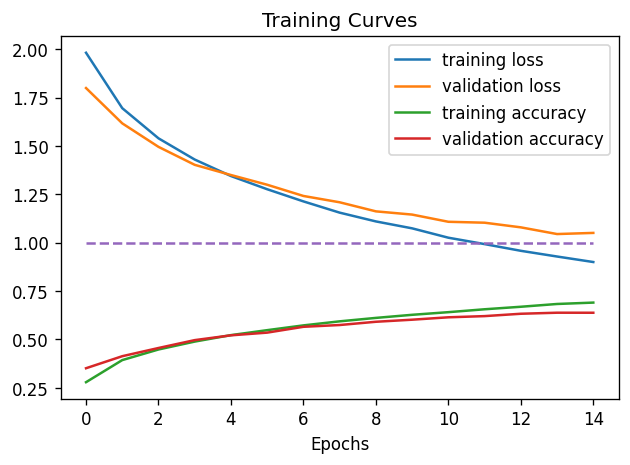

Accuracy of the network on the 10000 test images : 63.92 %


In [42]:
tuned_lr = 0.00001
tune_opti_lr("RMSprop", tuned_lr)

### 3.3.2. Optimizer: RMSprop; Learning Rate: 0.00005

Optimizer : RMSprop, Learning Rate : 5e-05.
-----------------------------------------------------------
epoch : 1
train loss : 1.7516, train accuracy : 35.96 %
val loss : 1.5177, val accuracy : 45.30 %
----------------------------------------------
epoch : 2
train loss : 1.3656, train accuracy : 51.42 %
val loss : 1.2826, val accuracy : 55.32 %
----------------------------------------------
epoch : 3
train loss : 1.1898, train accuracy : 58.59 %
val loss : 1.1817, val accuracy : 59.34 %
----------------------------------------------
epoch : 4
train loss : 1.0779, train accuracy : 62.89 %
val loss : 1.0960, val accuracy : 62.05 %
----------------------------------------------
epoch : 5
train loss : 0.9946, train accuracy : 65.83 %
val loss : 1.0630, val accuracy : 64.54 %
----------------------------------------------
epoch : 6
train loss : 0.9311, train accuracy : 68.11 %
val loss : 1.0274, val accuracy : 65.55 %
----------------------------------------------
epoch : 7
train loss : 0.8

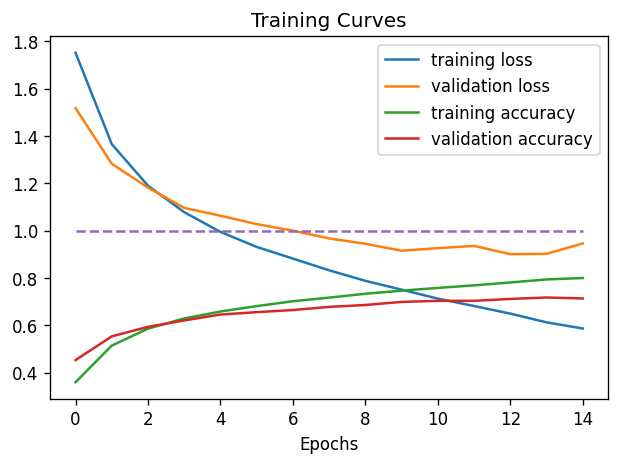

Accuracy of the network on the 10000 test images : 70.61 %


In [43]:
tuned_lr = 0.00005
tune_opti_lr("RMSprop", tuned_lr)

### 3.3.3. Optimizer: RMSprop; Learning Rate: 0.0001

Optimizer : RMSprop, Learning Rate : 0.0001.
-----------------------------------------------------------
epoch : 1
train loss : 1.7007, train accuracy : 37.55 %
val loss : 1.4307, val accuracy : 48.43 %
----------------------------------------------
epoch : 2
train loss : 1.2991, train accuracy : 54.21 %
val loss : 1.2126, val accuracy : 58.86 %
----------------------------------------------
epoch : 3
train loss : 1.1307, train accuracy : 60.77 %
val loss : 1.1053, val accuracy : 63.06 %
----------------------------------------------
epoch : 4
train loss : 1.0249, train accuracy : 65.06 %
val loss : 1.0477, val accuracy : 64.55 %
----------------------------------------------
epoch : 5
train loss : 0.9502, train accuracy : 67.84 %
val loss : 0.9867, val accuracy : 67.69 %
----------------------------------------------
epoch : 6
train loss : 0.8906, train accuracy : 70.15 %
val loss : 0.9746, val accuracy : 67.63 %
----------------------------------------------
epoch : 7
train loss : 0.

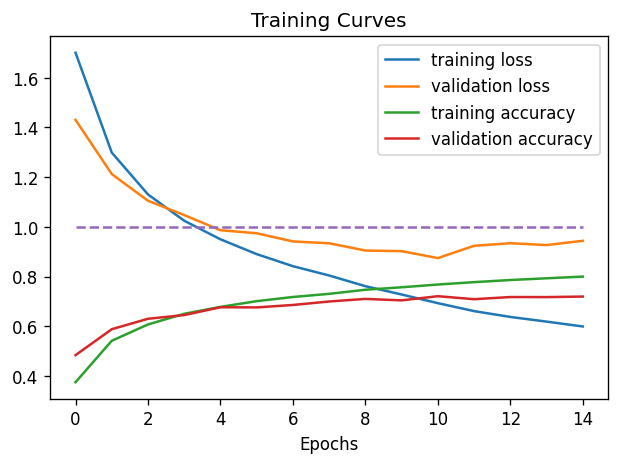

Accuracy of the network on the 10000 test images : 72.19 %


In [44]:
tuned_lr = 0.0001
tune_opti_lr("RMSprop", tuned_lr)

### 3.3.4. Optimizer: RMSprop; Learning Rate: 0.0005

Optimizer : RMSprop, Learning Rate : 0.0005.
-----------------------------------------------------------
epoch : 1
train loss : 1.8121, train accuracy : 33.23 %
val loss : 1.5829, val accuracy : 44.60 %
----------------------------------------------
epoch : 2
train loss : 1.3751, train accuracy : 51.71 %
val loss : 1.2949, val accuracy : 54.95 %
----------------------------------------------
epoch : 3
train loss : 1.1870, train accuracy : 59.38 %
val loss : 1.1469, val accuracy : 62.26 %
----------------------------------------------
epoch : 4
train loss : 1.0631, train accuracy : 63.88 %
val loss : 1.0896, val accuracy : 64.19 %
----------------------------------------------
epoch : 5
train loss : 0.9691, train accuracy : 67.54 %
val loss : 1.0104, val accuracy : 66.85 %
----------------------------------------------
epoch : 6
train loss : 0.8869, train accuracy : 70.75 %
val loss : 0.9813, val accuracy : 68.30 %
----------------------------------------------
epoch : 7
train loss : 0.

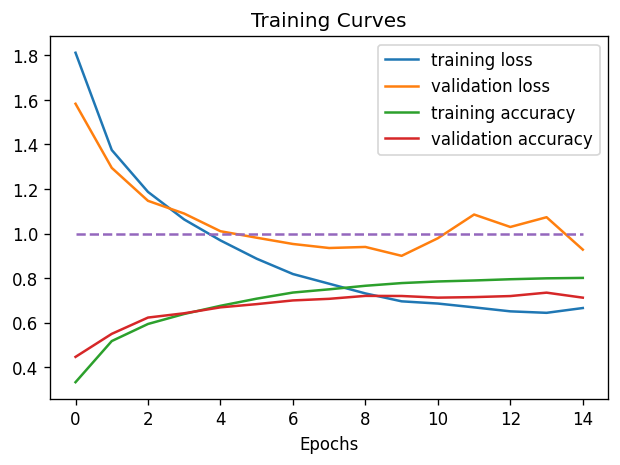

Accuracy of the network on the 10000 test images : 71.12 %


In [45]:
tuned_lr = 0.0005
tune_opti_lr("RMSprop", tuned_lr)

### 3.3.5. Optimizer: RMSprop; Learning Rate: 0.001

Optimizer : RMSprop, Learning Rate : 0.001.
-----------------------------------------------------------
epoch : 1
train loss : 2.0698, train accuracy : 21.83 %
val loss : 1.7836, val accuracy : 31.82 %
----------------------------------------------
epoch : 2
train loss : 1.5512, train accuracy : 43.87 %
val loss : 1.3799, val accuracy : 51.77 %
----------------------------------------------
epoch : 3
train loss : 1.2674, train accuracy : 55.76 %
val loss : 1.3084, val accuracy : 57.51 %
----------------------------------------------
epoch : 4
train loss : 1.1150, train accuracy : 61.86 %
val loss : 1.1492, val accuracy : 61.60 %
----------------------------------------------
epoch : 5
train loss : 1.0214, train accuracy : 65.53 %
val loss : 1.1234, val accuracy : 64.12 %
----------------------------------------------
epoch : 6
train loss : 0.9543, train accuracy : 68.22 %
val loss : 1.0690, val accuracy : 66.93 %
----------------------------------------------
epoch : 7
train loss : 0.9

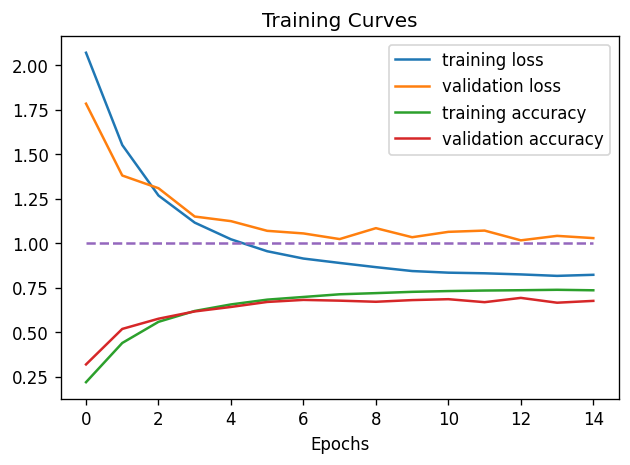

Accuracy of the network on the 10000 test images : 67.57 %


In [46]:
tuned_lr = 0.001
tune_opti_lr("RMSprop", tuned_lr)

### 3.3.6. Optimizer: RMSprop; Learning Rate: 0.005

Optimizer : RMSprop, Learning Rate : 0.005.
-----------------------------------------------------------
epoch : 1
train loss : 2.6528, train accuracy : 18.80 %
val loss : 1.8884, val accuracy : 27.64 %
----------------------------------------------
epoch : 2
train loss : 1.8304, train accuracy : 30.71 %
val loss : 1.7386, val accuracy : 34.74 %
----------------------------------------------
epoch : 3
train loss : 1.7190, train accuracy : 36.49 %
val loss : 1.7072, val accuracy : 36.71 %
----------------------------------------------
epoch : 4
train loss : 1.6394, train accuracy : 40.14 %
val loss : 1.6318, val accuracy : 42.60 %
----------------------------------------------
epoch : 5
train loss : 1.6032, train accuracy : 42.26 %
val loss : 1.5993, val accuracy : 42.45 %
----------------------------------------------
epoch : 6
train loss : 1.5676, train accuracy : 44.11 %
val loss : 1.5226, val accuracy : 45.21 %
----------------------------------------------
epoch : 7
train loss : 1.5

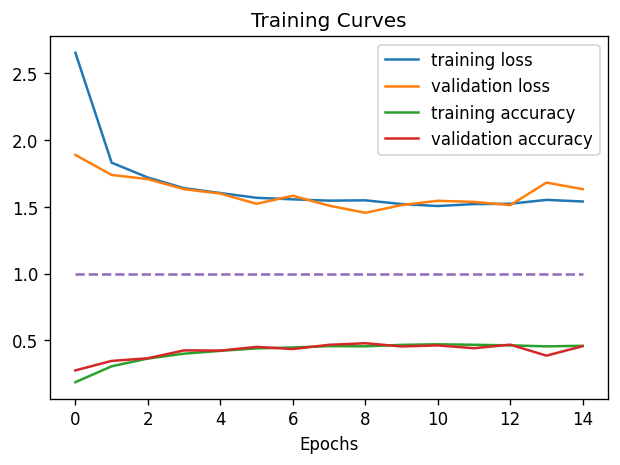

Accuracy of the network on the 10000 test images : 46.44 %


In [47]:
tuned_lr = 0.005
tune_opti_lr("RMSprop", tuned_lr)

### 3.3.7. Optimizer: RMSprop; Learning Rate: 0.01

Optimizer : RMSprop, Learning Rate : 0.01.
-----------------------------------------------------------
epoch : 1
train loss : 7.3891, train accuracy : 9.96 %
val loss : 2.3089, val accuracy : 9.78 %
----------------------------------------------
epoch : 2
train loss : 2.3155, train accuracy : 9.80 %
val loss : 2.3073, val accuracy : 10.33 %
----------------------------------------------
epoch : 3
train loss : 2.3074, train accuracy : 10.10 %
val loss : 2.3047, val accuracy : 10.37 %
----------------------------------------------
epoch : 4
train loss : 2.3063, train accuracy : 9.75 %
val loss : 2.3058, val accuracy : 9.93 %
----------------------------------------------
epoch : 5
train loss : 2.3049, train accuracy : 10.05 %
val loss : 2.3083, val accuracy : 9.92 %
----------------------------------------------
epoch : 6
train loss : 2.3046, train accuracy : 10.18 %
val loss : 2.3069, val accuracy : 9.83 %
----------------------------------------------
epoch : 7
train loss : 2.3053, tra

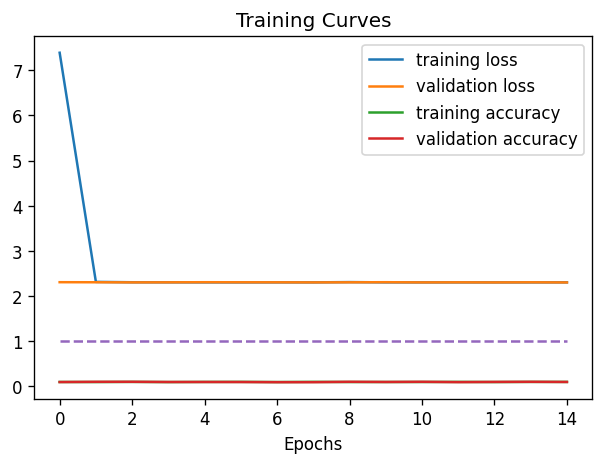

Accuracy of the network on the 10000 test images : 10.00 %


In [48]:
tuned_lr = 0.01
tune_opti_lr("RMSprop", tuned_lr)

### 3.3.8. Optimizer: RMSprop; Learning Rate: 0.05

Optimizer : RMSprop, Learning Rate : 0.05.
-----------------------------------------------------------
epoch : 1
train loss : 266.8003, train accuracy : 10.24 %
val loss : 2.5737, val accuracy : 10.10 %
----------------------------------------------
epoch : 2
train loss : 2.4669, train accuracy : 10.01 %
val loss : 2.3303, val accuracy : 9.57 %
----------------------------------------------
epoch : 3
train loss : 2.5008, train accuracy : 9.86 %
val loss : 2.5101, val accuracy : 9.84 %
----------------------------------------------
epoch : 4
train loss : 2.3351, train accuracy : 9.96 %
val loss : 2.3071, val accuracy : 10.38 %
----------------------------------------------
epoch : 5
train loss : 2.3597, train accuracy : 10.02 %
val loss : 2.3141, val accuracy : 10.07 %
----------------------------------------------
epoch : 6
train loss : 2.3217, train accuracy : 10.14 %
val loss : 2.3187, val accuracy : 9.84 %
----------------------------------------------
epoch : 7
train loss : 2.3142,

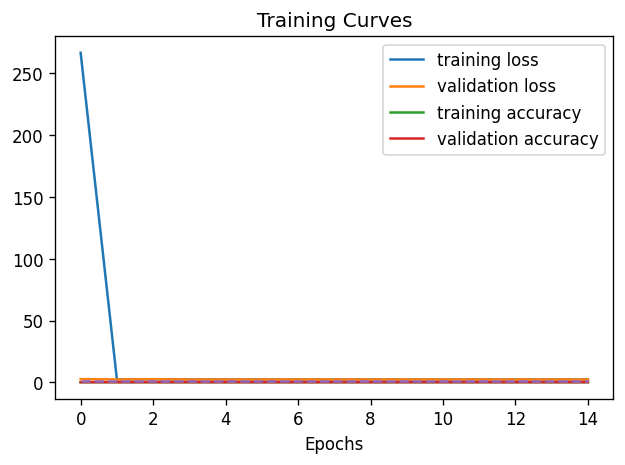

Accuracy of the network on the 10000 test images : 10.00 %


In [49]:
tuned_lr = 0.05
tune_opti_lr("RMSprop", tuned_lr)

### 3.3.9. Optimizer: RMSprop; Learning Rate: 0.1

Optimizer : RMSprop, Learning Rate : 0.1.
-----------------------------------------------------------
epoch : 1
train loss : 2926.9131, train accuracy : 9.87 %
val loss : 2.3457, val accuracy : 10.34 %
----------------------------------------------
epoch : 2
train loss : 2.3383, train accuracy : 9.97 %
val loss : 2.3258, val accuracy : 9.97 %
----------------------------------------------
epoch : 3
train loss : 2.3276, train accuracy : 9.95 %
val loss : 2.3752, val accuracy : 9.84 %
----------------------------------------------
epoch : 4
train loss : 2.3282, train accuracy : 10.03 %
val loss : 2.3264, val accuracy : 9.48 %
----------------------------------------------
epoch : 5
train loss : 2.3323, train accuracy : 10.02 %
val loss : 2.3234, val accuracy : 10.07 %
----------------------------------------------
epoch : 6
train loss : 2.3292, train accuracy : 9.87 %
val loss : 2.3275, val accuracy : 10.07 %
----------------------------------------------
epoch : 7
train loss : 2.3309, t

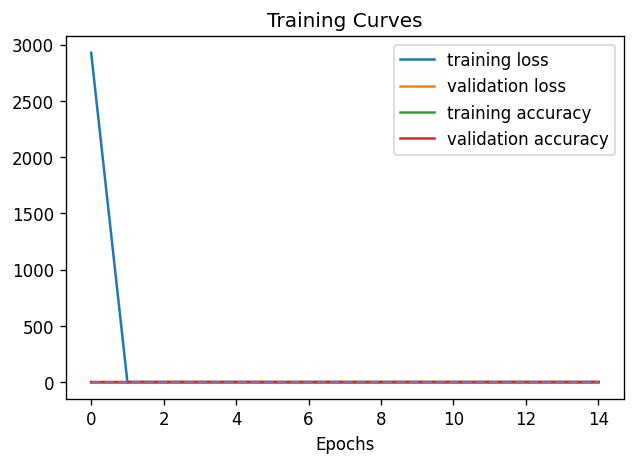

Accuracy of the network on the 10000 test images : 10.00 %


In [50]:
tuned_lr = 0.1
tune_opti_lr("RMSprop", tuned_lr)

**Comments on RMSprop optimizer:**

|LR     |Train %|Val %  |Tr-Val%|Test % |
|:------|-------|-------|-------|-------|
|0.00001| 69.05 | 63.80 |  5.25 | 63.92 |  
|0.00005| 79.97 | 71.34 |  8.63 | 70.61 |  
|0.0001 | 80.02 | 71.99 |  8.03 | 72.19 |  
|0.0005 | 80.07 | 71.20 |  8.87 | 71.12 |  
|0.001  | 73.48 | 67.53 |  5.95 | 67.57 |  
|0.005  | 46.03 | 45.74 |  0.28 | 46.44 |  
|0.01   |   -   |   -   |   -   |   -   | 
|0.05   |   -   |   -   |   -   |   -   |
|0.1    |   -   |   -   |   -   |   -   |

**Best optimizer and learning rate**

Network3 tuned with Optimizer: SGD with Momentum = 0.9, learning rate = 0.001